In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import os
import collections
import math 
from sklearn import preprocessing
from IPython.display import display, HTML

#from experiments.models import Analysis
#from compound.models import Pathway, CompoundPathway, Compound
#from data.models import Peak, Dataset, PeakDTSample, PeakQCSample
#from fileupload.models import Sample
from collections import defaultdict
#from experiments.pipelines.pipeline_rpy2 import Rpy2PipelineMetadata
#from experiments.pipelines.helpers import convert_to_dataframe

### Construct a several pathways with 2 fold changes in the data (noise with std of 5 added)

In [3]:
sample_fnames = [u'Control_4.mzXML', u'Control_3.mzXML', u'Control_2.mzXML', 
           u'Control_1.mzXML', u'Neg_fold_1.mzXML', u'Neg_fold_2.mzXML', u'Neg_fold_3.mzXML', u'Neg_fold_4.mzXML']
data_names ={"two":2, "four":4, "six":6, "ten":10, "twenty":20, "forty":40, "eighty":80}

### Set up a DF calcutating the T-test scores and the number of metabolites

In [4]:
from scipy.stats import ttest_ind
condition_1 = [u'Control_4.mzXML', u'Control_3.mzXML', u'Control_2.mzXML', u'Control_1.mzXML']
condition_2 = [u'Neg_fold_1.mzXML', u'Neg_fold_2.mzXML', u'Neg_fold_3.mzXML', u'Neg_fold_4.mzXML']


### A method to add a percentage of random peaks to a peak intensity df

In [5]:
def add_random_peaks(int_df, percent):

    #For each of the pathways add random peaks
    rand_peak_list = []   
    for name in data_names:

        df_path = int_df.loc[name]
        num_peaks = math.ceil((df_path.shape[0])*(percent/100.0))

        num_samples = df_path.shape[1]
        
        #Generate random peaks for that pathway
        
        for p in range(int(num_peaks)):
            rand_peaks = []
            data = np.random.normal(0, 5, num_samples)
            rand_peaks.append(name)
            rand_peaks.extend(list(data))
            rand_peak_list.append(rand_peaks)

    #Construct a DF for the new peak list
    ran_df = pd.DataFrame(rand_peak_list).set_index([0])
    ran_df.columns=sample_fnames
    
    #Add the random peaks to the original DF
    new_df = pd.concat([int_df, ran_df])
    
    scaled_data = preprocessing.scale(np.array(new_df), axis=1)
    new_df[sample_fnames] = scaled_data
    
    return new_df
    
   

### Method to return p-value and t-test for an activity DF

In [6]:
def get_t_test(noisy_df):

    t_test_list = []

    for pathway, row in noisy_df.iterrows():
        c1 = noisy_df.loc[pathway, condition_1].values
        c2 = noisy_df.loc[pathway, condition_2].values
        path_params = [pathway] + list(ttest_ind(c1,c2))
        t_test_list.append(path_params)

    t_test_df = pd.DataFrame(t_test_list).set_index([0])
    t_test_df.columns = ['t-stat', 'EA_Score']

    t_test_df = t_test_df.sort_values(by='EA_Score', ascending = True)

    return t_test_df


### Method to return the peak activities given a peak DF composed of pathways

In [7]:
def get_pathway_act(int_df):
    #For all of the pathways get all of the peak IDs
    pathway_activities = []
    for name in data_names:
        pathway_peaks = int_df.loc[name] #DF selected from peak IDs.
        w, d, c = np.linalg.svd(np.array(pathway_peaks))
        pw_act_list = []
        pw_act_list.append(name)
        pw_act_list.extend(list(c[0]))

        pathway_activities.append(pw_act_list)
        
        
        activity_df = pd.DataFrame(pathway_activities).set_index([0])
        activity_df.columns=int_df.columns
        activity_df.index.name = "Pathways"


    return activity_df


In [8]:
def construct_fc_df(random=False):
    sample_fnames = [u'Control_4.mzXML', u'Control_3.mzXML', u'Control_2.mzXML', 
           u'Control_1.mzXML', u'Neg_fold_1.mzXML', u'Neg_fold_2.mzXML', u'Neg_fold_3.mzXML', u'Neg_fold_4.mzXML']
    data_names ={"two":2, "four":4, "six":6, "ten":10, "twenty":20, "forty":40, "eighty":80}

    if not random:
        data = [12.0, 12.0, 6.0, 6.0, -7.0, -7.0, -17.0, -17.0]
    else:
        data = data = np.random.normal(0, 1, 8)
    pk_samp_intensities = []
    for name, num in data_names.items():
        for n in range(num):
                peak_int_list =[]
                peak_int_list.append(name) 
                data_noise = data + np.random.normal(0, 5, len(data))
                peak_int_list.extend(list(data_noise)) #The intensities of all the samples for this peak.
                pk_samp_intensities.append(peak_int_list)

    fc_df = pd.DataFrame(pk_samp_intensities).set_index([0])

    fc_df.columns=sample_fnames
    fc_df.index.name = "ms1_peak_id"
    fc_df.columns.name ="sample_name"

    scaled_data = preprocessing.scale(np.array(fc_df), axis=1)

    fc_df[sample_fnames] = scaled_data
    
    
    return fc_df



### Constuct the df*num_iterations and calculate the mean t-test scores


In [15]:
def calc_av_p_scores(num_iterations, percent=None, random=False):
    
    for it in range(num_iterations):
        fc_df = construct_fc_df(random) #Construct the fold change DF
        pathway_acts = get_pathway_act(fc_df)

        #If we want to add a percentatge of random peaks
        if percent is not None:
            add_random_df = add_random_peaks(fc_df, percent)
            pathway_acts = get_pathway_act(add_random_df)
        #Calulate the t-test results, if it is the first iteration, initialise the df.
        if it == 0:   
            t_results = get_t_test(pathway_acts).sort_index(axis=0)      
        
        else:  
            t_results = t_results + get_t_test(pathway_acts).sort_index(axis=0)      

    final = t_results/num_iterations
    new_df = final.sort_values(by='EA_Score', ascending = True)
    
    return new_df


In [16]:
fc_df = construct_fc_df(random=False)

In [17]:
display(fc_df.head())

sample_name,Control_4.mzXML,Control_3.mzXML,Control_2.mzXML,Control_1.mzXML,Neg_fold_1.mzXML,Neg_fold_2.mzXML,Neg_fold_3.mzXML,Neg_fold_4.mzXML
ms1_peak_id,,,,,,,,
two,1.066470,1.388058,-0.181862,0.764574,-0.476579,0.197167,-1.025729,-1.732099
two,1.194040,0.862207,0.782626,0.637518,-0.065087,-0.352372,-1.479437,-1.579494
four,1.036030,1.203439,0.873317,0.798030,-0.685316,-0.965951,-1.378110,-0.881439
four,1.645240,0.907181,0.503122,0.665857,-0.560334,-0.844026,-0.981010,-1.336030
four,1.227965,1.088522,0.345535,0.565268,0.083457,-0.208842,-1.492602,-1.609304


### Heat map of the fold change matrix

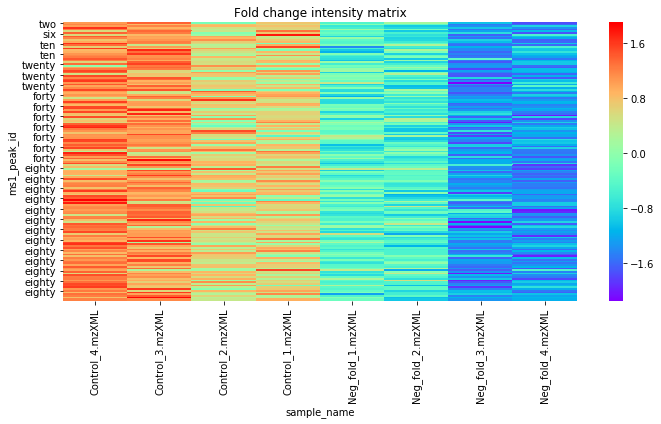

In [18]:
import seaborn as sns; 
plt.figure(figsize=(10, 6))
sns.heatmap(fc_df, cmap="rainbow")
plt.title("Fold change intensity matrix")
plt.tight_layout()
plt.savefig("fold_change.png", dpi=300)

### Box-plotting


#### Example

In [19]:
def construct_single_box_df(df, random_peaks):
    columns = ['Pathway', "Random_peaks", "EA_Score"]
    box_plot_df = pd.DataFrame(columns=columns)
    box_plot_df.Pathway = list(df.index)
    box_plot_df.Random_peaks=float(random_peaks)
    box_plot_df.EA_Score = df.EA_Score.values
    
    return box_plot_df


In [20]:
reqd_senarios = [[100,0],[100,50],[100,100],[100,200],[100,300], [100,1000]]

In [22]:
columns = ['Pathway', "Random_peaks", "EA_Score"]
box_plot_df = pd.DataFrame(columns=columns)
for rq_s in reqd_senarios:
    if rq_s[1]==0:
        df = calc_av_p_scores(rq_s[0])
        single_box_df = construct_single_box_df(df,0)
    elif rq_s[1]=="random = True":
        df = calc_av_p_scores(rq_s[0], random=True)
        single_box_df = construct_single_box_df(df,100)
    else:
        random = (rq_s[1]/(rq_s[1]+100))*100
        df = calc_av_p_scores(rq_s[0], rq_s[1])
        single_box_df = construct_single_box_df(df,random)
    box_plot_df = box_plot_df.append(single_box_df, ignore_index=True)
display (box_plot_df.head())

    
    

,Pathway,Random_peaks,EA_Score
0,eighty,0.0,0.000822
1,forty,0.0,0.000926
2,twenty,0.0,0.000987
3,ten,0.0,0.001144
4,six,0.0,0.001561


In [ ]:
box_plot_df.Random_peaks.astype(float)

In [23]:
box_plot_df.dtypes

Pathway          object
Random_peaks    float64
EA_Score        float64
dtype: object

In [24]:
box_df = box_plot_df.round({'Random_peaks': 1})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


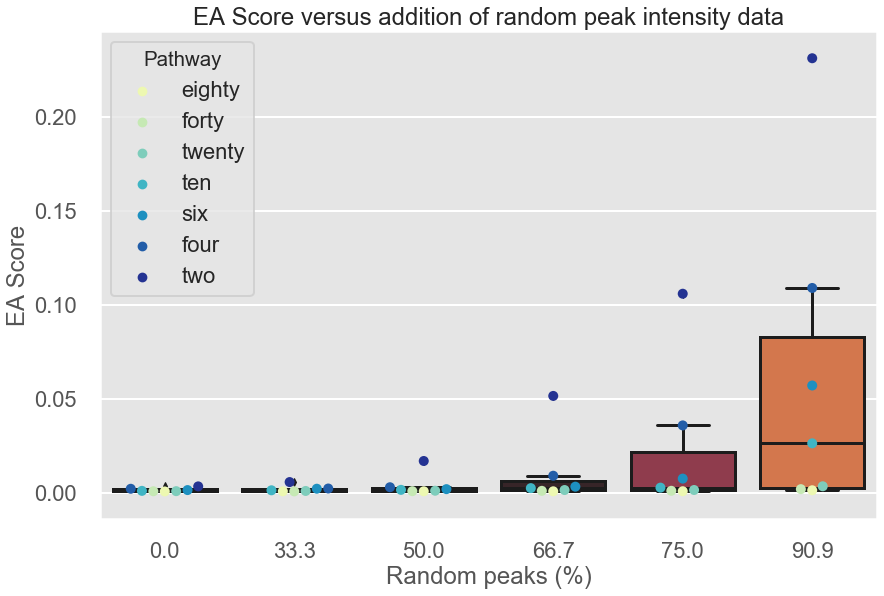

In [88]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger
ax = sns.boxplot(x="Random_peaks", y="EA_Score", data=box_df, palette=("icefire"))
ax = sns.swarmplot(x="Random_peaks", y="EA_Score", hue="Pathway", data=box_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Random peaks (%)', ylabel='EA Score')
plt.title("EA Score versus addition of random peak intensity data")
plt.tight_layout()
plt.savefig("box_plot.eps", dpi=300)

<Figure size 921.6x633.6 with 0 Axes>

### Sampling the p-values over a pathways with a number of different peaks ( none random )

In [ ]:
no_change_df = calc_av_p_scores(100)
display (no_change_df)

In [ ]:
plt.plot(no_change_df['EA_Score'])

### Adding a pecentage of random peaks to the pathways STD = 5

In [ ]:
random_50_df = calc_av_p_scores(100,50)
display (random_50_df)

In [ ]:
plt.plot(random_50_df['EA_Score'])

In [ ]:
random_100_df = calc_av_p_scores(100,100)
display (random_100_df)

In [ ]:
random_200_df = calc_av_p_scores(100,200)
display (random_200_df)

In [ ]:
random_1000_df = calc_av_p_scores(100,1000)
display (random_1000_df)

### Adding a pecentage of random peaks to the pathways STD = 1

In [ ]:
random_50_df_1 = calc_av_p_scores(100,50)
display (random_50_df_1)

In [ ]:
random_100_df_1 = calc_av_p_scores(100,100)
display (random_100_df_1)

In [ ]:
random_200_df_1 = calc_av_p_scores(100,200)
display (random_200_df_1)

### Nothing is changing, it's all random

In [ ]:
all_random = calc_av_p_scores(100, random = True)
display (all_random)